In [1]:
import re
import pandas as pd
import numpy as np
from numpy import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

Reading the datasets.
Applying label encoder and then concatenate the two datasets

In [2]:

df = pd.read_excel('hatespeech_text.xlsx', header = None)
df.rename(columns={0:'tweets', 1:'labels'}, inplace=True)
print(df.head(10))


                                              tweets   labels
0  RT @Papapishu: Man it would fucking rule if we...  hateful
1  It is time to draw close to Him &#128591;&#127...   normal
2  if you notice me start to act different or dis...   normal
3  Forget unfollowers, I believe in growing. 7 ne...   normal
4  RT @Vitiligoprince: Hate Being sexually Frustr...  hateful
5  Topped the group in TGP Disc Jam Season 2! Ont...   normal
6  That daily baby aspirin for your #heart just m...   normal
7  I liked a @YouTube video from @mattshea https:...   normal
8  RT @LestuhGang_: If your fucking up &amp; your...  hateful
9  @Move_Fwd give up. You've lost. You will not c...   normal


In [3]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['labels']=le.fit_transform(df['labels'])
df.head()

,tweets,labels
0,RT @Papapishu: Man it would fucking rule if we...,0
1,It is time to draw close to Him &#128591;&#127...,1
2,if you notice me start to act different or dis...,1
3,"Forget unfollowers, I believe in growing. 7 ne...",1
4,RT @Vitiligoprince: Hate Being sexually Frustr...,0


In [4]:
de=pd.read_pickle("./emoji_tweets.pkl")
emoji = pd.DataFrame.from_dict(de)
emoji.head()


,tweets,labels
0,lmfaoo 😭 😭 😭 😭 😭,0
1,i hate this feeling 😢,0
2,can't believe i just went out in this cold to ...,0
3,"i need a new trap house, so if you really fuck...",0
4,<user> so very sorry for your loss. 💔,0


In [5]:
data = pd.concat([df,emoji])
data.head()
data.tweets=data.tweets.astype(str)

Pre Processing
 1-> For hate speech detection as the dataset contains tweets along with the actual tweets some of them include the Twitter handle of people, hashtags, links to certain websites or the tweet itself
First, we replace all tags and hashtags with space using regex (@ [^\s] + which means replace anything which @ accompanied by anything but a space). Then we replace all the website links with a space.
For hate speech detection as the dataset contains tweets along with the actual tweets some of them include the Twitter handle of people, hashtags, links to certain websites or the tweet itself and emoticons. We add rt to stopwords which represents retweet. First, we replace all tags and hashtags with space using regex (@ [^\s] + which means replace anything which @ accompanied by anything but a space). Then we replace all the website links with a space.
Then we split the sentence into words and check if the word is present in stopwords we remove it and then again join the sentence. We then replace multiple spaces with a single space, strip the sentences for extra trailing spaces. we replace nan (not a number) values with a space and finally drop any missing values.


In [6]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords

STOPWORDS = stopwords.words('english')
STOPWORDS.append("rt")
STOPWORDS.append("<user>")
STOPWORDS.append("<url>")
def clean_text():
    data["tweets"] = data["tweets"].apply(lambda x: x.lower())
    data["tweets"] = [re.sub('(@[^\s]+)|(#[^\s]+)', '', tweet) for tweet in data["tweets"]]
    data["tweets"] = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet) for tweet in data["tweets"]]
    data["tweets"] = data["tweets"].str.split(' ').apply(lambda tweet: ' '.join(k for k in tweet if k not in STOPWORDS))
    data["tweets"] = data["tweets"].str.replace(' +', ' ', case=False)
    data["tweets"] = data["tweets"].str.strip()
    data["tweets"].replace('', np.nan, inplace=True)
    df.dropna(subset=["tweets"], inplace=True)
      
clean_text()
    
print(data.head(10))
print(data.tail(10))
len(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-6-5c6ab3fd789f>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  data["tweets"] = data["tweets"].str.replace(' +', ' ', case=False)


                                              tweets  labels
0    man would fucking rule party perpetual warfare.       0
1      time draw close & father, draw near always ❤️       1
2  notice start act different distant.. bc peeped...       1
3  forget unfollowers, believe growing. 7 new fol...       1
4  hate sexually frustrated like wanna fuck ion w...       0
5  topped group tgp disc jam season 2! onto semi-...       1
6     daily baby aspirin might preventing colon too.       1
7  liked video blue army coming! - ancient warfare 2       1
8  fucking &amp; homies dont tell fucking up, ain...       0
9  give up. lost. convince one iota read conspira...       1
                                                  tweets  labels
13190  clear message. use helmet save life 👇 \n\n<use...       1
13191                         funny 😆 wish could get one       1
13192                        show respect, get respect ☝       1
13193                              waahh im happy you! 💖       1
1319

85966

For emoticon function first we tokenize each word of the sentence using word_tokenize. Then we check whether the word is a emoji or not if no we add if to sentence else we convert the emoji into its corresponding meaning (ie 😀 turns to smile) using the emoji.demojize function imported from library emoji , convert the customary ':' sign attached to it to a space, remove extra spaces and then add it to the sentence.

In [7]:
import emoji
def emoticon(sentence):
    words=word_tokenize(sentence)
    stem_sentence=[]
    for word in words:
        if emoji.demojize(word)== None:
            stem_sentence.append(word)
            stem_sentence.append(" ")
        else:
            word= emoji.demojize(word)
            word = word.replace(":"," ")
            stem_sentence.append(word)
            stem_sentence.append(" ")
    return "".join(stem_sentence)
    
training_size = 1000000        
sentences = data.tweets.astype(str)
sentences = sentences[:training_size].apply(emoticon)
sentences.head()
sentences.tail()

13195    love waking skinny ahaha wish lasted day  grin...
13196    magnificent pair tits  smiling_face_with_heart...
13197    soon mamsh  face_blowing_a_kiss  god give best...
13198              trust u  smiling_face_with_sunglasses  
13199         aww thanks  beaming_face_with_smiling_eyes  
Name: tweets, dtype: object

Here we convert our words into root words after analyzing its context in the sentence.

In [8]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer

def stemSentence(sentence):
    lemmatizer = WordNetLemmatizer()
    stemmer = LancasterStemmer()
    words=word_tokenize(sentence)
    stem_sentence=[]
    for word in words:
        stem_sentence.append(lemmatizer.lemmatize(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)
training_size = 1000000
sentences = sentences[:training_size].apply(stemSentence)
sentences.head()
sentences.tail()

13195    love waking skinny ahaha wish lasted day grinn...
13196    magnificent pair tit smiling_face_with_heart-e...
13197    soon mamsh face_blowing_a_kiss god give best a...
13198                trust u smiling_face_with_sunglasses 
13199           aww thanks beaming_face_with_smiling_eyes 
Name: tweets, dtype: object

Splitting the dataset into 70:30 

In [9]:
from sklearn.model_selection import train_test_split

# Data splitting
X = sentences
y = data["labels"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

print ('Total   tweet count:', len(data))
print ('Normal  tweet count:', len(data[data.labels == 1]))
print ('Hateful tweet count:', len(data[data.labels == 0]), '\n')
print ('Total tweet count in training sampple:', len(X_train))
print ('Total tweet count in test sample:    ', len(X_test))
print ('Normal  tweet count in X_train:', X_train[y_train == 1].count())
print ('Hateful tweet count in X_train:', X_train[y_train == 0].count())
print ('Normal  tweet count in X_test: ', X_test[y_test == 1].count())
print ('Hateful tweet count in X_test: ', X_test[y_test == 0].count())

Total   tweet count: 99166
Normal  tweet count: 60450
Hateful tweet count: 38716 

Total tweet count in training sampple: 69416
Total tweet count in test sample:     29750
Normal  tweet count in X_train: 42344
Hateful tweet count in X_train: 27072
Normal  tweet count in X_test:  18106
Hateful tweet count in X_test:  11644


Fitting and transforming tfidfvectorizer on training sentences and transforming testing sentences based on training sentences
Create a pickle file containing tfidf fitted vectorizer so that we can call in our python file

In [10]:
import pickle
cv = CountVectorizer()
tfidftrans = TfidfVectorizer()
X_train = tfidftrans.fit_transform(X_train)
print(X_train.shape)
pickle.dump(tfidftrans, open("tfidf.pickle", "wb"))

(69416, 49382)


In [11]:
X_test = tfidftrans.transform(X_test)
print(X_test.shape)

(29750, 49382)


Feeding the data to MultinomialNB, KNN ,Logistic regression, Decision Tree
Adding the accuracy scores to a dictionary to compare later

In [13]:
def training(clf,x_train,Y_train):
    clf.fit(x_train,Y_train)
def predict(clf,X_test):
    return clf.predict(X_test)
dict={}
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB(alpha =0.2)
training(mnb,X_train,y_train)
pred = predict(mnb,X_test)
print(accuracy_score(y_test,pred,normalize=True))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test,pred))
dict[mnb]=accuracy_score(y_test,pred,normalize=True)

0.8883361344537816
              precision    recall  f1-score   support

           0       0.88      0.83      0.85     11644
           1       0.89      0.93      0.91     18106

    accuracy                           0.89     29750
   macro avg       0.89      0.88      0.88     29750
weighted avg       0.89      0.89      0.89     29750

[[ 9665  1979]
 [ 1343 16763]]


In [14]:
from sklearn.neighbors import KNeighborsClassifier
for i in range(1,5):
    knn = KNeighborsClassifier(n_neighbors=i)
    training(knn,X_train,y_train)
    pred = predict(knn,X_test)
    print('k = ',i)
    print(accuracy_score(y_test,pred,normalize=True))
    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test,pred))
    dict[knn,i]=accuracy_score(y_test,pred,normalize=True)

k =  1
0.7767394957983194
              precision    recall  f1-score   support

           0       0.90      0.48      0.63     11644
           1       0.74      0.97      0.84     18106

    accuracy                           0.78     29750
   macro avg       0.82      0.72      0.73     29750
weighted avg       0.80      0.78      0.76     29750

[[ 5632  6012]
 [  630 17476]]
k =  2
0.776235294117647
              precision    recall  f1-score   support

           0       0.88      0.50      0.63     11644
           1       0.75      0.96      0.84     18106

    accuracy                           0.78     29750
   macro avg       0.81      0.73      0.74     29750
weighted avg       0.80      0.78      0.76     29750

[[ 5769  5875]
 [  782 17324]]
k =  3
0.7519663865546219
              precision    recall  f1-score   support

           0       0.94      0.39      0.55     11644
           1       0.72      0.98      0.83     18106

    accuracy                           0.75

In [15]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
training(dt,X_train,y_train)
pred = predict(dt,X_test)
print(accuracy_score(y_test,pred,normalize=True))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test,pred))
dict[dt]=accuracy_score(y_test,pred,normalize=True)

0.9166050420168067
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     11644
           1       0.94      0.93      0.93     18106

    accuracy                           0.92     29750
   macro avg       0.91      0.91      0.91     29750
weighted avg       0.92      0.92      0.92     29750

[[10491  1153]
 [ 1328 16778]]


In [16]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)
training(lr,X_train,y_train)
pred = predict(lr,X_test)
print(accuracy_score(y_test,pred,normalize=True))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test,pred))
dict[lr]=accuracy_score(y_test,pred,normalize=True)

0.9355294117647058
              precision    recall  f1-score   support

           0       0.95      0.88      0.91     11644
           1       0.93      0.97      0.95     18106

    accuracy                           0.94     29750
   macro avg       0.94      0.93      0.93     29750
weighted avg       0.94      0.94      0.94     29750

[[10250  1394]
 [  524 17582]]


Finding model with highest accuracy and creating a pickle file of respective model to call in python file

In [17]:
n=max(dict.values())
print(n)
for name,predicted in dict.items():
    if predicted==n:
        print(name)
        model=name

0.9355294117647058
LogisticRegression(max_iter=10000)


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\stride_tricks.py:116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  array = np.array(array, copy=False, subok=subok)


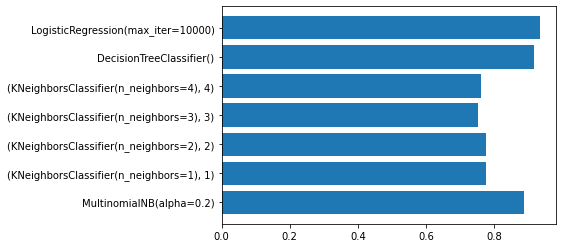

In [18]:
import matplotlib.pyplot as plt
names = list(dict.keys())
values = list(dict.values())
plt.barh(range(len(dict)), values, tick_label=names)
plt.show()

In [19]:
import pickle
with open('hate_speech.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=4)

TESTING

In [21]:
sentence = input("sentence: ")
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('(@[^\s]+)|(#[^\s]+)', '', sentence)
    sentence = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',sentence)
    sentence = re.sub(r'[ ]+', ' ', sentence)
    words = word_tokenize(sentence)
    words = [word for word in words if not word in STOPWORDS]
    clean_sentence=[]
    for word in words:
        clean_sentence.append(" ")
    return "".join(clean_sentence)
clean_text(sentence)
sentence=emoticon(sentence)
stemmed = stemSentence(sentence)
sentence=[stemmed]
sentence = tfidftrans.transform(sentence)
print('normal' if lr.predict(sentence)==1 else 'hateful')

sentence: I fucking hate you😠
hateful
